#SAITEJA CHEKURI, VIT25

# Titanic analysis of data with TensorFlow Decision Forests

This notebook takes you through training a baseline Gradient Boosted Trees (GBT) model with TensorFlow Decision Forests for the Titanic challenge. It includes steps that are mandatory, like minimal pre-processing, i.e., tokenizing passenger names and ticket name splitting into parts. The notebook begins with training a GBT model with default parameters and then refines it by modifying default settings for improved performance. It also touches upon parameter tuning to further optimize the model. It then shows how to train and ensemble multiple GBT models to enhance overall accuracy, resulting in an optimized submission for the challenge.

# Imports dependencies

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
pip install tensorflow_decision_forests

In [3]:
import numpy as np
import pandas as pd
import os

import tensorflow as tf
import tensorflow_decision_forests as tfdf

print(f"Found TF-DF {tfdf.__version__}")

Found TF-DF 1.12.0


# Load dataset

In [4]:
train_df = pd.read_csv("//content//drive//MyDrive//Projects//titanic//train.csv")
serving_df = pd.read_csv("//content//drive//MyDrive//Projects//titanic//test.csv")

train_df.head(10)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
5,6,0,3,"Moran, Mr. James",male,NaN,0,0,330877,8.4583,NaN,Q
6,7,0,1,"McCarthy, Mr. Timothy J",male,54.0,0,0,17463,51.8625,E46,S
7,8,0,3,"Palsson, Master. Gosta Leonard",male,2.0,3,1,349909,21.0750,NaN,S
8,9,1,3,"Johnson, Mrs. Oscar W (Elisabeth Vilhelmina Berg)",female,27.0,0,2,347742,11.1333,NaN,S
9,10,1,2,"Nasser, Mrs. Nicholas (Adele Achem)",female,14.0,1,0,237736,30.0708,NaN,C


# Prepare dataset

We will carry out the following operations on the dataset.

1. Tokenize the names. That is, "Braund, Mr. Owen Harris" will be tokenized as ["Braund", "Mr.", "Owen", "Harris"].
2. Pull out any prefix from the ticket. Such as ticket "STON/O2. 3101282" will now be "STON/O2." and 3101282.

In [5]:
def preprocess(df):
    df = df.copy()

    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])

    def ticket_number(x):
        return x.split(" ")[-1]

    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])

    df["Name"] = df["Name"].apply(normalize_name)
    df["Ticket_number"] = df["Ticket"].apply(ticket_number)
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    return df

preprocessed_train_df = preprocess(train_df)
preprocessed_serving_df = preprocess(serving_df)

preprocessed_train_df.head(5)

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked,Ticket_number,Ticket_item
0,1,0,3,Braund Mr Owen Harris,male,22.0,1,0,A/5 21171,7.2500,NaN,S,21171,A/5
1,2,1,1,Cumings Mrs John Bradley Florence Briggs Thayer,female,38.0,1,0,PC 17599,71.2833,C85,C,17599,PC
2,3,1,3,Heikkinen Miss Laina,female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S,3101282,STON/O2.
3,4,1,1,Futrelle Mrs Jacques Heath Lily May Peel,female,35.0,1,0,113803,53.1000,C123,S,113803,NONE
4,5,0,3,Allen Mr William Henry,male,35.0,0,0,373450,8.0500,NaN,S,373450,NONE


Let's keep the list of the input features of the model. Notably, we don't want to train our model on the "PassengerId" and "Ticket" features.

In [6]:
input_features = list(preprocessed_train_df.columns)
input_features.remove("Ticket")
input_features.remove("PassengerId")
input_features.remove("Survived")
#input_features.remove("Ticket_number")

print(f"Input features: {input_features}")

Input features: ['Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'Cabin', 'Embarked', 'Ticket_number', 'Ticket_item']


# Convert Pandas dataset to TensorFlow Dataset

In [7]:
def tokenize_names(features, labels=None):
    """Divite the names into tokens. TF-DF can consume text tokens natively."""
    features["Name"] =  tf.strings.split(features["Name"])
    return features, labels

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_train_df,label="Survived").map(tokenize_names)
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(preprocessed_serving_df).map(tokenize_names)

# Train model with default parameters

### Train model

Firstly, we have trained a GradientBoostedTreesModel model with the default parameters.

In [8]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True, # Only use the features in "features"
    random_seed=1234,
)
model.fit(train_ds)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

Accuracy: 0.8260869383811951 Loss:0.8608942627906799


# Train model with improved default parameters

Now we will use some specific parameters when creating the GBT model

In [9]:
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=0, # Very few logs
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True, # Only use the features in "features"
    min_examples=1,
    categorical_algorithm="RANDOM",
    #max_depth=4,
    shrinkage=0.05,
    #num_candidate_attributes_ratio=0.2,
    split_axis="SPARSE_OBLIQUE",
    sparse_oblique_normalization="MIN_MAX",
    sparse_oblique_num_projections_exponent=2.0,
    num_trees=2000,
    #validation_ratio=0.0,
    random_seed=1234,

)
model.fit(train_ds)

self_evaluation = model.make_inspector().evaluation()
print(f"Accuracy: {self_evaluation.accuracy} Loss:{self_evaluation.loss}")

Accuracy: 0.75 Loss:1.0462466478347778


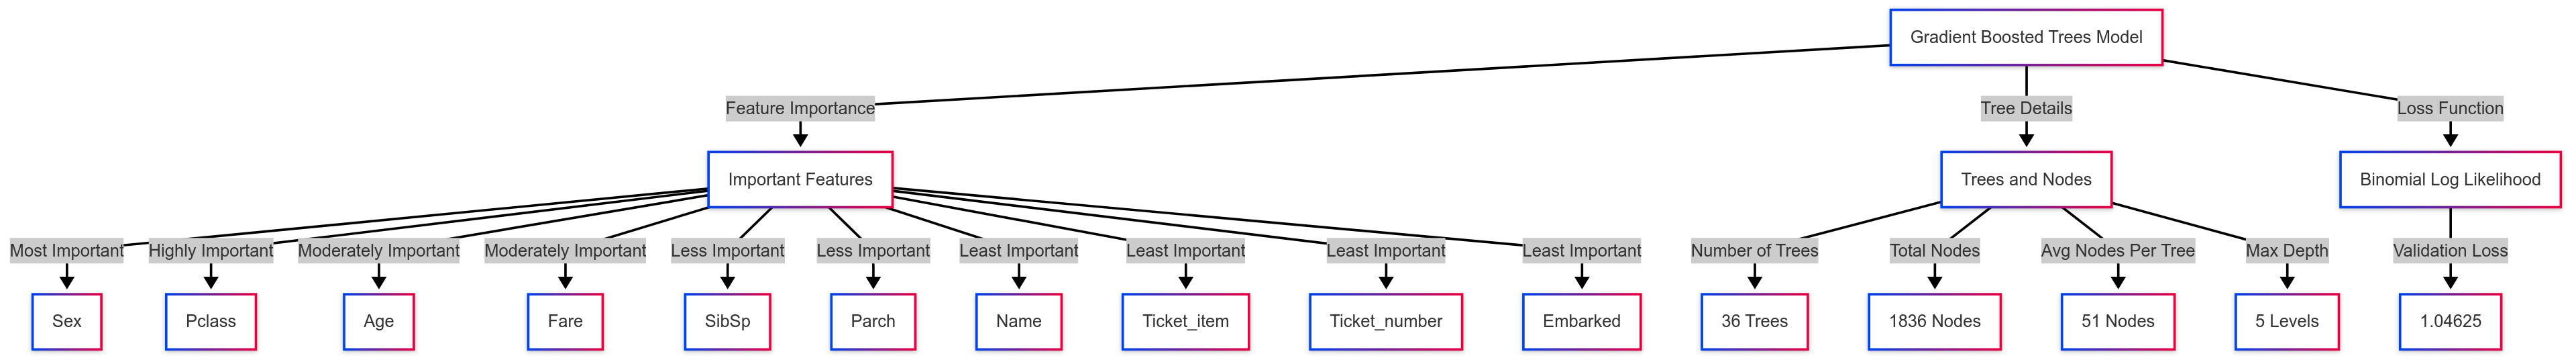

Let's look at the model and you can also notice the information about variable importance that the model figured out

In [10]:
model.summary()

Model: "gradient_boosted_trees_model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (11):
	Age
	Cabin
	Embarked
	Fare
	Name
	Parch
	Pclass
	Sex
	SibSp
	Ticket_item
	Ticket_number

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.           "Sex"  0.805245 ################
    2.        "Pclass"  0.449931 ######
    3.           "Age"  0.372369 ####
    4.          "Fare"  0.350024 ####
    5.         "SibSp"  0.284882 ##
    6.         "Parch"  0.263519 ##
    7.          "Name"  0.187307 
    8.   "Ticket_item"  0.178416 
    9. "Ticket_number"  0.178366 
   10.      "Embarked"  0.176070 

Variable Importance: NUM_AS_ROOT:
    1.  "Sex" 34.000000

# Make predictions

In [15]:
def prediction_to_kaggle_format(model, threshold=0.5):
    proba_survive = model.predict(serving_ds, verbose=0)[:,0]
    return pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (proba_survive >= threshold).astype(int)
    })

def make_submission(kaggle_predictions):
    path="//content//drive//MyDrive//Projects//titanic//submission.csv"
    kaggle_predictions.to_csv(path, index=False)
    print(f"Submission exported to {path}")

kaggle_predictions = prediction_to_kaggle_format(model)
make_submission(kaggle_predictions)
!head //content//drive//MyDrive//Projects//titanic//submission.csv

Submission exported to //content//drive//MyDrive//Projects//titanic//submission.csv
PassengerId,Survived
892,0
893,1
894,0
895,0
896,1
897,0
898,1
899,0
900,1


# Training a model with hyperparameter tunning




In [13]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

#tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])


tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=0)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Use /tmp/tmp_roqsi3a as temporary training directory


Accuracy: 0.8630136847496033 Loss:0.6749962568283081


# Making an ensemble



In [14]:
predictions = None
num_predictions = 0

for i in range(100):
    print(f"i:{i}")
    # Possible models: GradientBoostedTreesModel or RandomForestModel
    model = tfdf.keras.GradientBoostedTreesModel(
        verbose=0, # Very few logs
        features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
        exclude_non_specified_features=True, # Only use the features in "features"

        #min_examples=1,
        #categorical_algorithm="RANDOM",
        ##max_depth=4,
        #shrinkage=0.05,
        ##num_candidate_attributes_ratio=0.2,
        #split_axis="SPARSE_OBLIQUE",
        #sparse_oblique_normalization="MIN_MAX",
        #sparse_oblique_num_projections_exponent=2.0,
        #num_trees=2000,
        ##validation_ratio=0.0,
        random_seed=i,
        honest=True,
    )
    model.fit(train_ds)

    sub_predictions = model.predict(serving_ds, verbose=0)[:,0]
    if predictions is None:
        predictions = sub_predictions
    else:
        predictions += sub_predictions
    num_predictions += 1

predictions/=num_predictions

kaggle_predictions = pd.DataFrame({
        "PassengerId": serving_df["PassengerId"],
        "Survived": (predictions >= 0.5).astype(int)
    })

make_submission(kaggle_predictions)

i:0


i:1


i:2


i:3
i:4
i:5
i:6
i:7
i:8
i:9
i:10
i:11
i:12
i:13
i:14
i:15
i:16
i:17
i:18
i:19
i:20
i:21
i:22
i:23
i:24
i:25
i:26
i:27
i:28
i:29
i:30
i:31
i:32
i:33
i:34
i:35
i:36
i:37
i:38
i:39
i:40
i:41
i:42
i:43
i:44
i:45
i:46
i:47
i:48
i:49
i:50
i:51
i:52
i:53
i:54
i:55
i:56
i:57
i:58
i:59
i:60
i:61
i:62
i:63
i:64
i:65
i:66
i:67
i:68
i:69
i:70
i:71
i:72
i:73
i:74
i:75
i:76
i:77
i:78
i:79
i:80
i:81
i:82
i:83
i:84
i:85
i:86
i:87
i:88
i:89
i:90
i:91
i:92
i:93
i:94
i:95
i:96
i:97
i:98
i:99
Submission exported to //content//drive//MyDrive//Projects//titanic//submission.csv


In [17]:
# Assuming you have a DataFrame named 'df' with a 'Survived' column
survivor_count = train_df['Survived'].sum()
non_survivor_count = len(train_df) - survivor_count

print(f"Total Survivors: {survivor_count}")
print(f"Total Non-Survivors: {non_survivor_count}")


Total Survivors: 342
Total Non-Survivors: 549


#We can conclude that there were 342 survivors and 549 are the non-survivors.